## Initialization
It installs the `Biopython` package.
Google Drive mount is only required if Google Colab is used.

In [ ]:
!pip install Bio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Initialize the dataframe
The required structure is the following,



In [20]:
from Bio import SeqIO
import pandas as pd

# Consensus sequence
REFDIR = "/content/drive/MyDrive/Purdue/Elancco/find_common/cs_updated.fasta"
# cs -> Consensus Sequence
cs_dict = SeqIO.to_dict(SeqIO.parse(REFDIR, "fasta"))
all_genes = list(cs_dict.keys())
all_genes.sort(key= lambda x: x.replace("IG", ''))

In [21]:
# Create a dataframe
import pandas as pd
entire_dataframe = pd.DataFrame(columns=['Dog', 'Breed'] + all_genes)
entire_dataframe.set_index(['Dog'], inplace=True)
# entire_dataframe now consist of all the gene under consideration.
print(entire_dataframe)

Empty DataFrame
Columns: [Breed, IGHV1-30, IGHV3-10, IGHV3-13, IGHV3-16, IGHV3-18, IGHV3-19, IGHV3-2, IGHV3-23, IGHV3-24, IGHV3-3, IGHV3-32, IGHV3-35, IGHV3-37, IGHV3-38, IGHV3-39, IGHV3-41, IGHV3-44, IGHV3-46, IGHV3-47, IGHV3-5, IGHV3-50, IGHV3-54, IGHV3-58, IGHV3-6, IGHV3-61, IGHV3-67, IGHV3-69, IGHV3-7, IGHV3-70, IGHV3-75, IGHV3-76, IGHV3-8, IGHV3-80, IGHV3-81, IGHV3-82, IGHV3-9, IGHV4-1, IGKV2-10, IGKV2-11, IGKV2-4, IGKV2-5, IGKV2-6, IGKV2-7, IGKV2-8, IGKV2-9, IGKV4-15, IGLV1-100, IGLV1-103, IGLV1-106, IGLV1-111, IGLV1-116, IGLV1-125, IGLV1-144, IGLV1-157, IGLV1-158, IGLV1-162, IGLV1-37, IGLV1-41, IGLV1-44, IGLV1-46, IGLV1-48, IGLV1-49, IGLV1-50, IGLV1-55, IGLV1-56, IGLV1-57, IGLV1-58, IGLV1-66, IGLV1-67, IGLV1-70, IGLV1-72, IGLV1-73, IGLV1-75, IGLV1-82, IGLV1-84, IGLV1-86, IGLV1-87, IGLV1-92, IGLV1-94, IGLV1-96, IGLV2-31, IGLV3-11, IGLV3-14, IGLV3-19, IGLV3-2, IGLV3-21, IGLV3-24, IGLV3-25, IGLV3-26, IGLV3-27, IGLV3-28, IGLV3-29, IGLV3-3, IGLV3-30, IGLV3-4, IGLV3-8, IGLV4-10, IGLV4

In [ ]:
# Get all the aligned Sequences
## For the time being it's just `IGHV`
# SEQDIR = "/content/drive/MyDrive/Purdue/Elancco/CDR-IGHV"
# DOGNAME = "Beagle01_extracted_gene_regions.csv"

In [22]:
import pandas as pd
from Bio import pairwise2
from Bio.Seq import Seq

> In case we want to map individual dogs to breeds the following will be need. Otherwise, please make sure to remove the `Breed` column. It can be done with `entire_dataframe.drop(columns=['Breed'])`

In [23]:
# Map dog to breed
mapping = pd.read_csv('/content/drive/MyDrive/Purdue/Elancco/find_common/find_common.csv')
cleared_mapping = mapping[['Sample Name', 'Breed/Type']]
cleared_mapping['Breed'] = cleared_mapping['Breed/Type']
cleared_mapping = cleared_mapping.drop(columns=['Breed/Type'])
cleared_mapping.set_index('Sample Name', inplace=True)
cleared_mapping.Breed = cleared_mapping.Breed.apply(lambda x: 'CKCS' if 'Cavalier King Charles Spaniel' in x else x)
print(cleared_mapping.Breed.to_list())

['Pomeranian', 'Pomeranian', 'Pomeranian', 'Pomeranian', 'Pomeranian', 'Pomeranian', 'Pomeranian', 'Pomeranian', 'Pomeranian', 'Whippet', 'Whippet', 'Whippet', 'Whippet', 'Whippet', 'Whippet', 'Portuguese Water Dog', 'Portuguese Water Dog', 'Portuguese Water Dog', 'Portuguese Water Dog', 'Portuguese Water Dog', 'Portuguese Water Dog', 'Portuguese Water Dog', 'Portuguese Water Dog', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Dachshund', 'Brittany', 'Brittany', 'Brittany', 'Brittany', 'Brittany', 'Brittany', 'Brittany', 'Brittany', 'Bouvier des Flandres', 'Bouvier des Flandres', 'Bouvier des Flandres', 'Bouvier des Flandres', 'Bouvier des Flandres', 'Bouvier des Flandres', 'Bouvier des Flandres', 'Bouvier des Flandres', 'Bouvier des Flandres', 'Bouvier des Flandres', 'Collie', 'Collie', 'Collie', 'Collie', 'Collie', 'Collie'

<ipython-input-23-45eaacc0f6a2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleared_mapping['Breed'] = cleared_mapping['Breed/Type']


## Calculate the conservation
The following lines of codes will calculate and store the conservation of each gene of each dog with the consensus sequence.

> **important** It will take a little time to calculate

In [24]:
import os
import pandas as pd
from collections import defaultdict
from Bio.Seq import Seq
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

genes = ['CDR-IGHV', 'CDR-IGKV', 'CDR-IGLV']
# genes = ['CDR-IGKV', 'CDR-IGLV']
for g in genes:
    print(f"\nProcessing gene group: {g}")
    curpath = f"/content/drive/MyDrive/Purdue/Elancco/{g}"

    for d in os.listdir(curpath):
        try:
            dog_dict = pd.read_csv(f"{curpath}/{d}")
        except Exception as e:
            print(f"Could not read file {d}: {e}")
            continue

        # Build full sequence
        dog_dict['full'] = (
            dog_dict['L-FR1'] + dog_dict['L-CDR1'] +
            dog_dict['L-FR2'] + dog_dict['L-CDR2'] +
            dog_dict['L-FR3'] + dog_dict['L-CDR3']
        )

        # Extract clean gene name
        def extract_gene(raw_gene):
            try:
                return raw_gene.split('_')[1].split('(')[0]
            except Exception:
                return raw_gene

        dog_dict['Gene'] = dog_dict['Gene'].apply(extract_gene)

        dog = defaultdict(float)
        dog_name = d.split("_")[0]

        for gene, ref_seq in cs_dict.items():
            match_rows = dog_dict[dog_dict['Gene'] == gene]

            if match_rows.empty:
                continue
            # if gene in ['IGKV2-11', 'IGKV4-15']:
            #     continue

            sample_seq = match_rows['full'].values[0]
            sample_seq = sample_seq.replace("-", "").replace("_", "")

            # Perform local alignment: match=1, mismatch=-1, gap_open=-0.5, gap_extend=-0.1
            alignments = pairwise2.align.localms(ref_seq.seq, sample_seq, 1, -1, -0.5, -0.1)
            best_alignment = alignments[0]
            aligned_ref, aligned_sample, score, start, end = best_alignment

            # Count exact matches in aligned region
            matches = sum(1 for a, b in zip(aligned_ref, aligned_sample) if a == b)
            similarity = matches / len(ref_seq.seq)
            dog[gene] = similarity

            # # Change
            # if gene == 'IGKV4-15':
            #     # print(f"Consensus Seq: {ref_seq.seq}")
            #     # print(f"Aligned Seq: {sample_seq}")
            #     # print(f"Similarity: {similarity}")
            #     # print(f"=======================================")
            #     print(f"{gene}: {dog_name} ({similarity:.2f})")
            #     print(format_alignment(*best_alignment, full_sequences=True))
            #     print("--------------------------")

            # Show low similarity pairs
            # if similarity < 0.6:
            #     print(f"{gene}: {dog_name} ({similarity:.2f})")
            #     print(format_alignment(*best_alignment, full_sequences=True))
            #     print("--------------------------")

        # Add breed
        dog['Breed'] = cleared_mapping.loc[dog_name].Breed if dog_name in cleared_mapping.index else "Unknown"

        # Save to final DataFrame
        entire_dataframe.loc[dog_name, dog.keys()] = dog.values()
        dog['Dog'] = dog_name



Processing gene group: CDR-IGHV

Processing gene group: CDR-IGKV

Processing gene group: CDR-IGLV
Could not read file .ipynb_checkpoints: [Errno 21] Is a directory: '/content/drive/MyDrive/Purdue/Elancco/CDR-IGLV/.ipynb_checkpoints'


In [ ]:
copy_dataframe = entire_dataframe.copy(deep=True)

In [25]:
entire_dataframe.set_index(['Breed'], inplace=False)
entire_dataframe.fillna(0, inplace=True)
entire_dataframe.sort_index()
entire_dataframe.columns
# entire_datafram = entire_dataframe.drop(columns=['IGKV2-11', 'IGKV4-15'])
print(entire_dataframe.columns)
# entire_dataframe['Dog']
# entire_dataframe.rep

Index(['Breed', 'IGHV1-30', 'IGHV3-10', 'IGHV3-13', 'IGHV3-16', 'IGHV3-18',
       'IGHV3-19', 'IGHV3-2', 'IGHV3-23', 'IGHV3-24',
       ...
       'IGLV5-64', 'IGLV5-85', 'IGLV8-102', 'IGLV8-108', 'IGLV8-128',
       'IGLV8-161', 'IGLV8-36', 'IGLV8-74-1', 'IGLV8-93', 'IGLV8-99'],
      dtype='object', length=113)


<ipython-input-25-4fdc2e20d089>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entire_dataframe.fillna(0, inplace=True)


In [26]:
# entire_dataframe.set_index(['Dog'])
for col in entire_dataframe.drop(columns='Breed').columns:
    # if col in ['IGKV2-11', 'IGKV4-15']:
    #     entire_dataframe = entire_dataframe.drop(columns=[col])
    #     continue
    entire_dataframe[col] = pd.to_numeric(entire_dataframe[col], errors='raise')


In [66]:
entire_dataframe['sum'] = entire_dataframe.drop(columns=["Breed"]).sum(axis=1)
entire_dataframe = entire_dataframe.sort_values(by='sum')
entire_dataframe = entire_dataframe.drop(columns=['sum'])

In [67]:
entire_dataframe

,Breed,IGHV1-30,IGHV3-10,IGHV3-13,IGHV3-16,IGHV3-18,IGHV3-19,IGHV3-2,IGHV3-23,IGHV3-24,...,IGLV5-64,IGLV5-85,IGLV8-102,IGLV8-108,IGLV8-128,IGLV8-161,IGLV8-36,IGLV8-74-1,IGLV8-93,IGLV8-99
Dog,,,,,,,,,,,,,,,,,,,,,
CLUPSE000001,Wolf,0.000000,1.000000,1.0,1.000000,0.928571,0.989796,0.969388,0.979592,0.959184,...,0.960396,0.93,1.00000,0.821053,0.946809,1.0,1.000000,0.978947,1.000000,1.0
BRMD000003,Bernese Mountain Dog,0.000000,0.989796,1.0,0.897959,0.969388,0.979592,0.918367,0.979592,0.959184,...,0.960396,0.93,0.98913,0.831579,0.957447,1.0,0.978723,0.989474,1.000000,1.0
CLUPRU000001,Wolf,0.000000,0.959184,1.0,1.000000,0.948980,0.989796,0.979592,0.959184,0.989796,...,0.930693,0.92,1.00000,0.800000,0.957447,1.0,1.000000,0.978947,1.000000,1.0
CLUPKG000001,Wolf,0.000000,1.000000,1.0,1.000000,0.887755,0.989796,0.989796,0.938776,0.979592,...,0.930693,0.93,1.00000,0.884211,0.936170,1.0,0.989362,0.968421,0.978947,1.0
BOUV000001,Bouvier des Flandres,0.000000,1.000000,1.0,1.000000,0.969388,0.969388,0.959184,1.000000,0.948980,...,0.930693,0.93,0.98913,0.831579,0.946809,1.0,0.978723,0.989474,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GOLD000007,Golden Retriever,0.938776,1.000000,1.0,1.000000,0.979592,0.979592,0.969388,0.989796,0.989796,...,1.000000,1.00,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
FBUL000003,French Bulldog,0.948980,1.000000,1.0,1.000000,0.979592,0.959184,0.969388,1.000000,0.959184,...,1.000000,1.00,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
GOLD000003,Golden Retriever,0.887755,1.000000,1.0,1.000000,0.979592,0.959184,0.969388,0.989796,0.969388,...,1.000000,1.00,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0


In [ ]:
entire_dataframe.drop(columns=["Breed"]).sum(axis=1)

,0
Dog,
CFA.117995,110.519201
Beagle01,109.590763
Beagle03,109.470896
Beagle04,109.351551
Beagle02,109.248330
...,...
YORK000005,109.020107
YORK000003,109.381707
YORK000002,109.126383


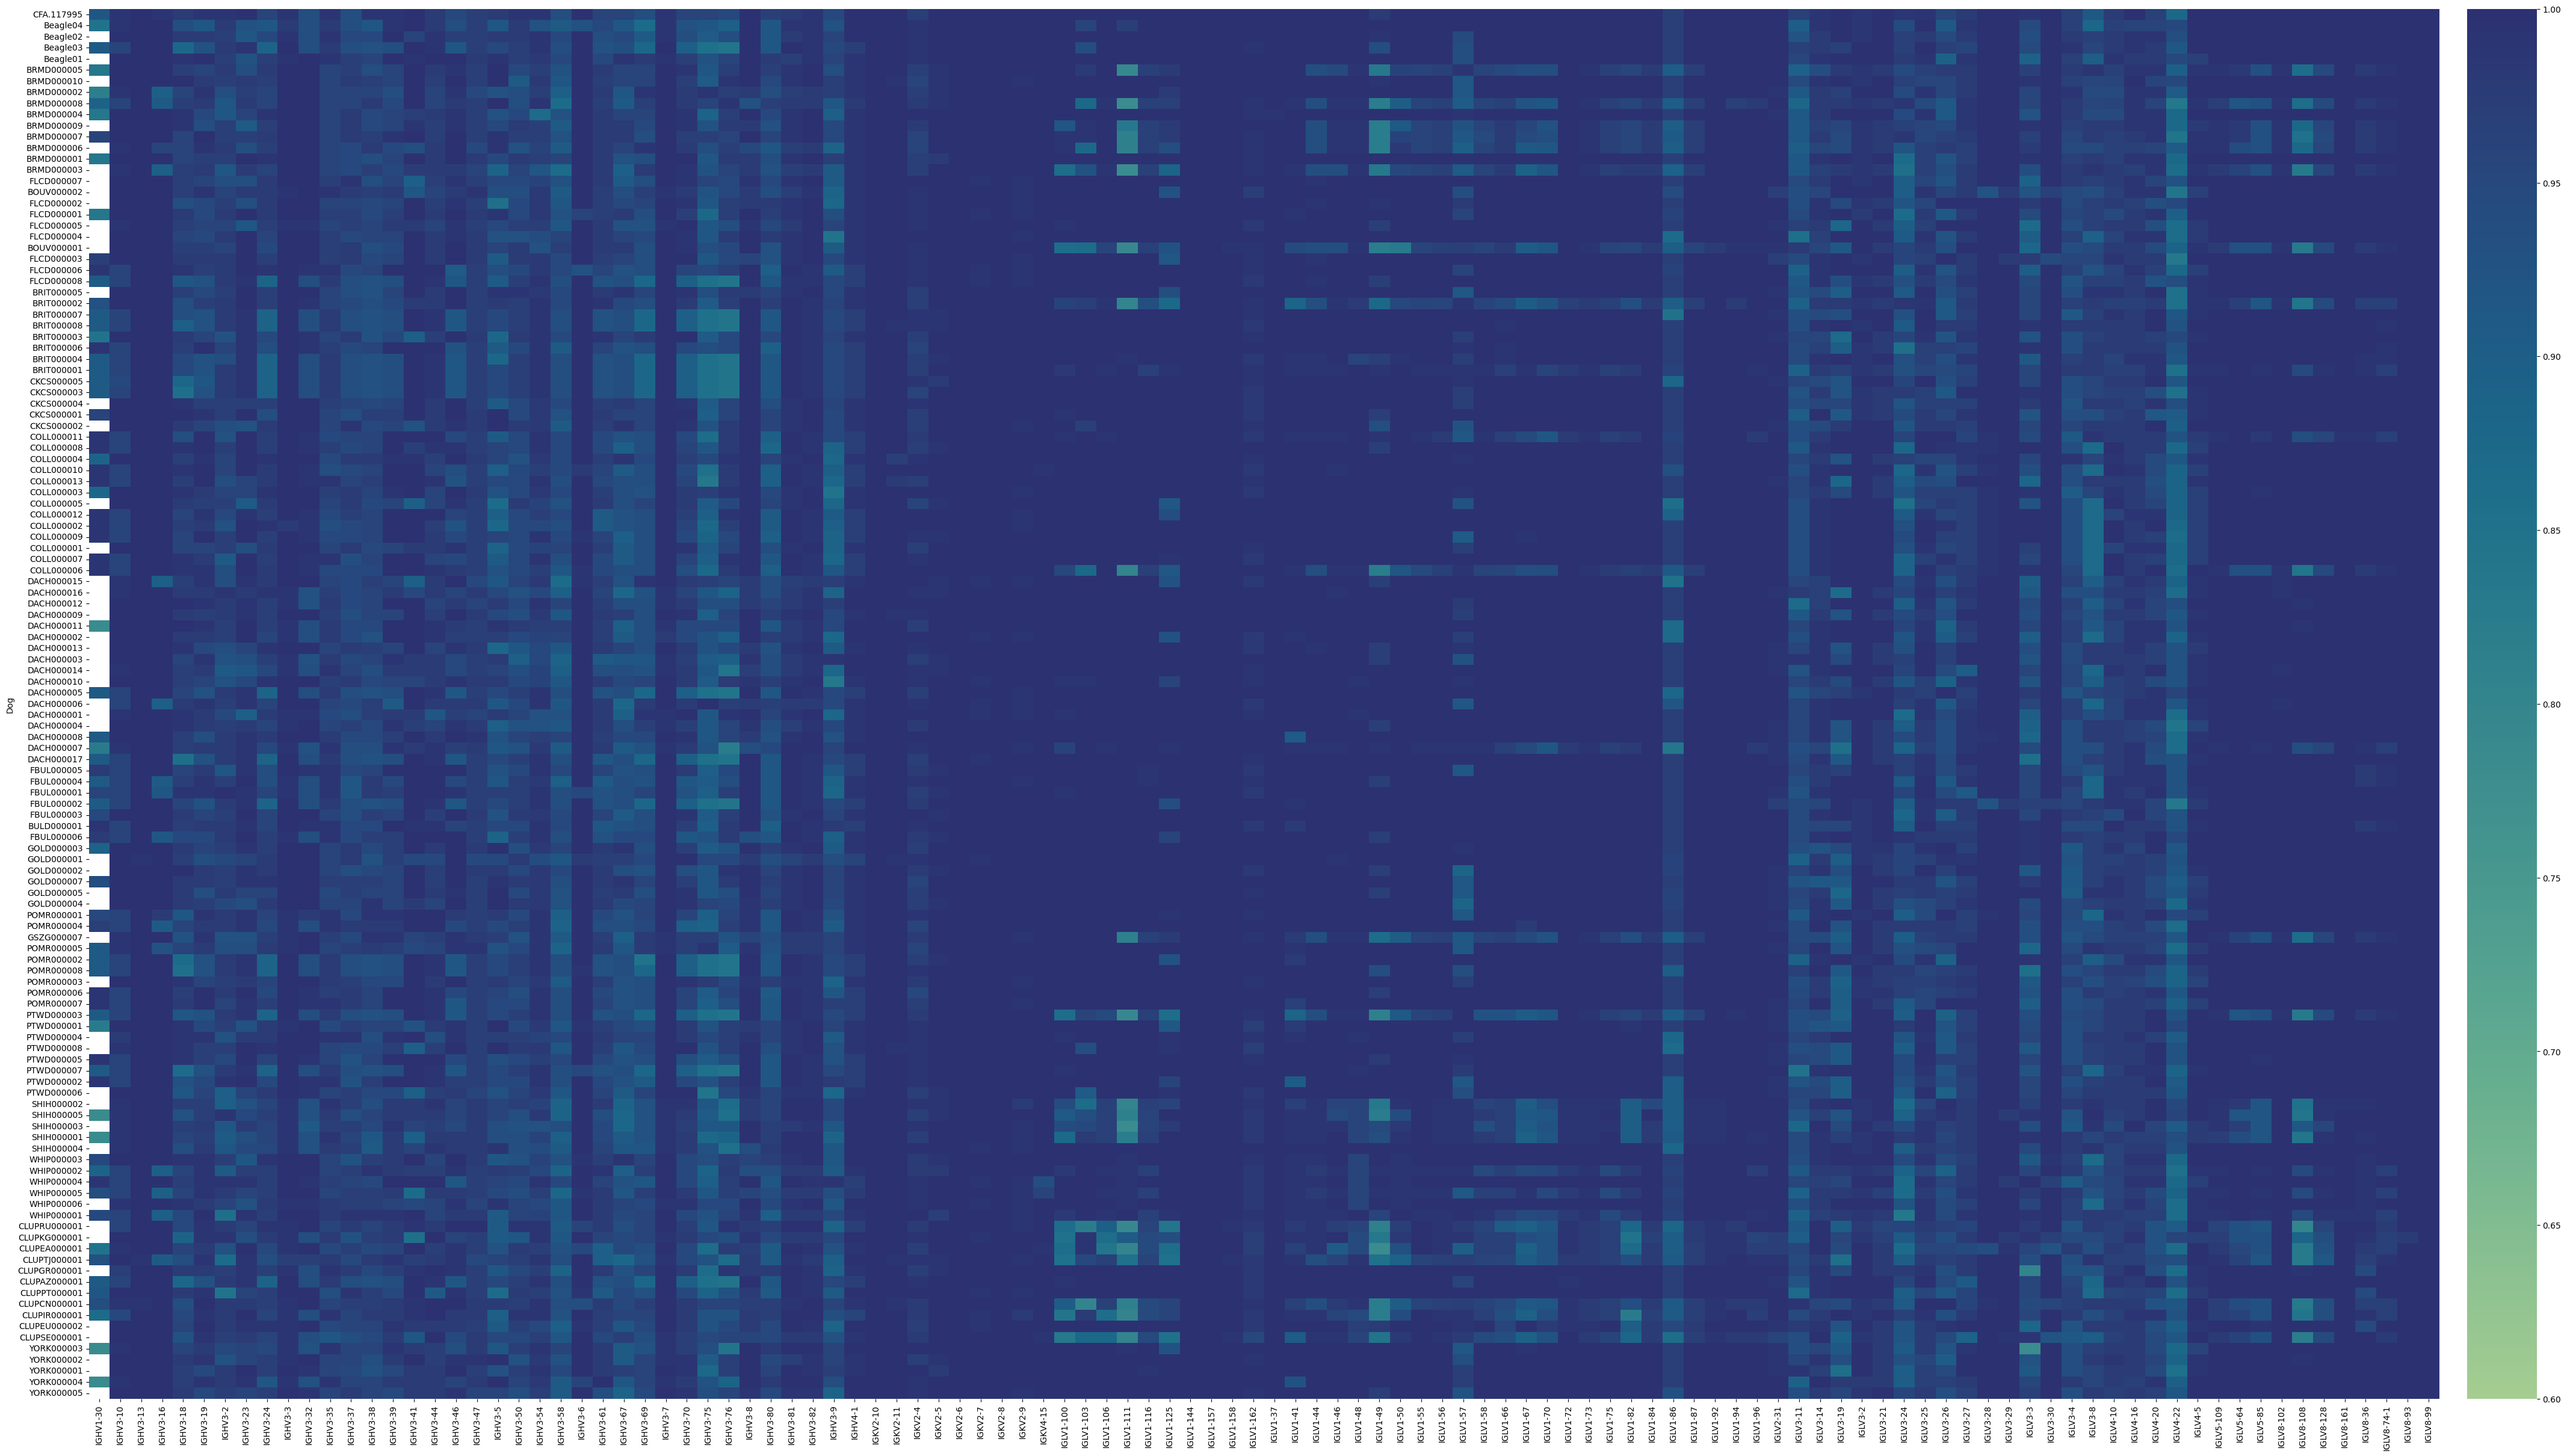

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
fig = plt.figure(figsize=(60, 30))  # Set figure size
ax = fig.add_subplot(111)
# ax.set_xticks([counter['IGHV'], counter['IGHV'] + counter['IGKV']], minor=True)
    # ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    # ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
# ax.grid(which="minor", color="black", linestyle='-', linewidth=2, axis='x')
# ax.tick_params(which="minor", bottom=False, left=False, length=0)
mask = np.ma.masked_where(entire_dataframe.drop(columns=["Breed"]).values < 0.5, entire_dataframe.drop(columns=["Breed"]).values)
im = sns.heatmap(entire_dataframe.drop(columns=["Breed"]), cmap='crest', linewidths=0, linecolor='white', ax=ax, cbar_kws={"pad": 0.01, "shrink": 1}, vmin=0.6, vmax=1, mask=entire_dataframe.drop(columns=["Breed"]).values == 0)
# im = sns.heatmap(entire_dataframe.drop(columns=["Breed"]), cmap='Blues', linewidths=0, linecolor='white', ax=ax, cbar_kws={"pad": 0.01, "shrink": 1}, vmin=0.6, vmax=1, mask=mask)
# plt.show()
plt.savefig("heatmap_sorted_by_conservation", bbox_inches="tight", pad_inches=0, dpi=300)
# for i in im.get_yticklabels():
#     im.set_yticklabels("BRUH", )
# im.set_yticks()


In [69]:
entire_dataframe = entire_dataframe.sort_values(['Breed'])

In [30]:
import numpy as np
import matplotlib
def heatmap(data, row_labels, col_labels, group_mapping, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    # ax.set_xticks(range(data.shape[1]), labels=col_labels,
    #               rotation=-30, ha="right", rotation_mode="anchor")
    ax.set_xticks([], labels=[])
    # ax.set_yticks(range(data.shape[0]), labels=row_labels )
    ax.set_yticks([], labels=[] )

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=False,
                   labeltop=False, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks([37-.5, 37+9-.5], minor=True)
    # ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    # ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2, axis='x')
    ax.tick_params(which="minor", bottom=False, left=False, length=0)

    # Add horizontal lines between different breeds
    breed_positions = []
    breed_name = []
    prev_breed = None
    for i, row in enumerate(row_labels):
        breed = group_mapping.loc[row].Breed
        # print(row, breed)
        if breed != prev_breed and prev_breed is not None:
            breed_positions.append(i - 0.5)
            breed_name.append(prev_breed)
        prev_breed = breed

    ax.set_yticks(breed_positions, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2, axis='y')
    ig_positions = []
    ig_names = ['IGHV', 'IGKV', 'IGLV']
    prev_col = None
    for i, ig in enumerate(col_labels):
        ig = ig.split('-')[0][0:4]
        if ig != prev_col and prev_col is not None:
            print(prev_col)
            ig_positions.append(i - 0.5)
        prev_col = ig.split('-')[0]

    print(ig_positions)
    for pos in breed_positions:
        ax.hlines(pos, color='black', linewidth=1, xmin=-40, xmax=111.6)

    ax.vlines(-0.5, ymin=-5, ymax=124.5, color='black', linewidth=1)
    for pos in ig_positions:
        ax.vlines(pos, ymin=-5, ymax=124.5, color='black', linewidth=1)
    ax.vlines(111.55, ymin=-5, ymax=124.5, color='black', linewidth=1)
    # Annotate breeds at the separation lines
    ax.hlines(0 - 0.5, color='black', linewidth=1, xmin=-40, xmax=111.6)
    ax.hlines(124.55, color='black', linewidth=1, xmin=-40, xmax=111.6)
    last_pos = 0
    for pos, breed in zip(breed_positions, breed_name):
        # breed = group_mapping.
        cur_pos = last_pos + (pos - last_pos) / 2
        ax.text(-1.5, cur_pos, breed, va='center', ha='right', fontsize=15)
        last_pos = pos
    ax.text(-1.5, last_pos + (124.5 - last_pos) / 2, prev_breed, va='center', ha='right', fontsize=15)
    print(f"THe last position is {last_pos}")
    last_pos = 0
    for pos, breed in zip(ig_positions, ig_names):
        # breed = group_mapping.
        cur_pos = last_pos + (pos - last_pos) / 2
        print(pos, breed)
        ax.text(cur_pos, -2.5, breed, va='center', ha='center', fontsize=15)
        last_pos = pos
    ax.text(last_pos + (124.5 - last_pos) / 2, -2.5, prev_col, va='center', ha='right', fontsize=15)

    return im, cbar

IGHV
IGKV
[36.5, 45.5]
THe last position is 119.5
36.5 IGHV
45.5 IGKV


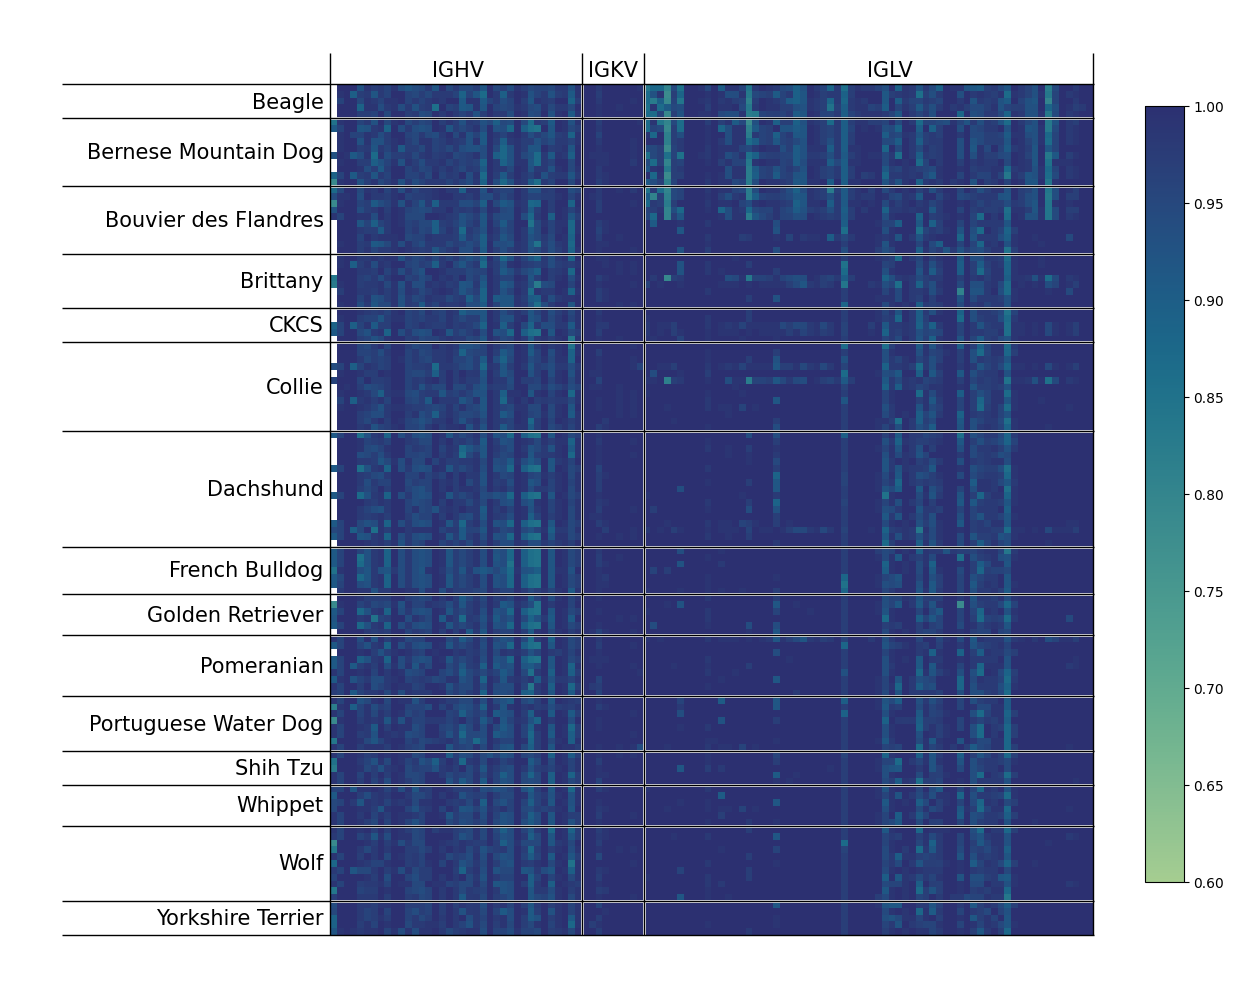

In [70]:
fig, ax = plt.subplots(figsize=(20, 10))

im, cbar = heatmap(mask, entire_dataframe.drop(columns=["Breed"]).index, entire_dataframe.drop(columns=["Breed"]).columns, cleared_mapping, ax=ax, cmap='crest', cbar_kw={"pad": 0.00, "shrink": 0.8}, vmin=0.6)
# texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.savefig("heatmap.png", bbox_inches="tight", pad_inches=0, dpi=300)
plt.show()


In [32]:
entire_dataframe = copy_dataframe.copy(deep=True)

NameError: name 'copy_dataframe' is not defined

In [33]:
from typing import DefaultDict
counter = DefaultDict(int)
for i in entire_dataframe.drop(columns=["Breed"]).columns:
    counter[i.split('-')[0][0:4]] += 1
counter

defaultdict(int, {'IGHV': 37, 'IGKV': 9, 'IGLV': 66, 'sum': 1})

In [ ]:
entire_dataframe.to_csv("gene conservation")

In [ ]:
entire_dataframe

,Breed,IGHV1-30,IGHV3-10,IGHV3-13,IGHV3-16,IGHV3-18,IGHV3-19,IGHV3-2,IGHV3-23,IGHV3-24,...,IGLV8-102,IGLV8-108,IGLV8-128,IGLV8-161,IGLV8-36,IGLV8-74-1,IGLV8-93,IGLV8-99,IGKV2-11,IGKV4-15
Dog,,,,,,,,,,,,,,,,,,,,,
CFA.117995,Beagle,0.918367,0.989796,1.0,0.989796,0.979592,0.989796,0.989796,1.000000,0.959184,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Beagle01,Beagle,0.000000,1.000000,1.0,1.000000,0.989796,1.000000,0.969388,0.928571,0.969388,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Beagle03,Beagle,0.908163,0.959184,1.0,1.000000,0.877551,0.928571,0.979592,0.989796,0.887755,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Beagle04,Beagle,0.846939,0.989796,1.0,1.000000,0.938776,0.918367,0.979592,0.928571,0.918367,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Beagle02,Beagle,0.000000,1.000000,1.0,1.000000,0.979592,0.979592,0.969388,0.918367,0.948980,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YORK000003,Yorkshire Terrier,0.785714,0.989796,1.0,1.000000,0.959184,0.979592,0.948980,0.959184,0.948980,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
YORK000002,Yorkshire Terrier,0.000000,1.000000,1.0,1.000000,0.979592,0.989796,0.928571,0.959184,0.969388,...,1.0,0.989474,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
YORK000001,Yorkshire Terrier,0.000000,1.000000,1.0,1.000000,0.969388,0.948980,0.979592,1.000000,0.969388,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [35]:
annotate = []
for i in tempdict:
    b = list(i)
    for index, j in enumerate(i):
        b[index] = ord(j)
    annotate.append(b)


Text(0.5, 1.0, 'IGKV4-15')

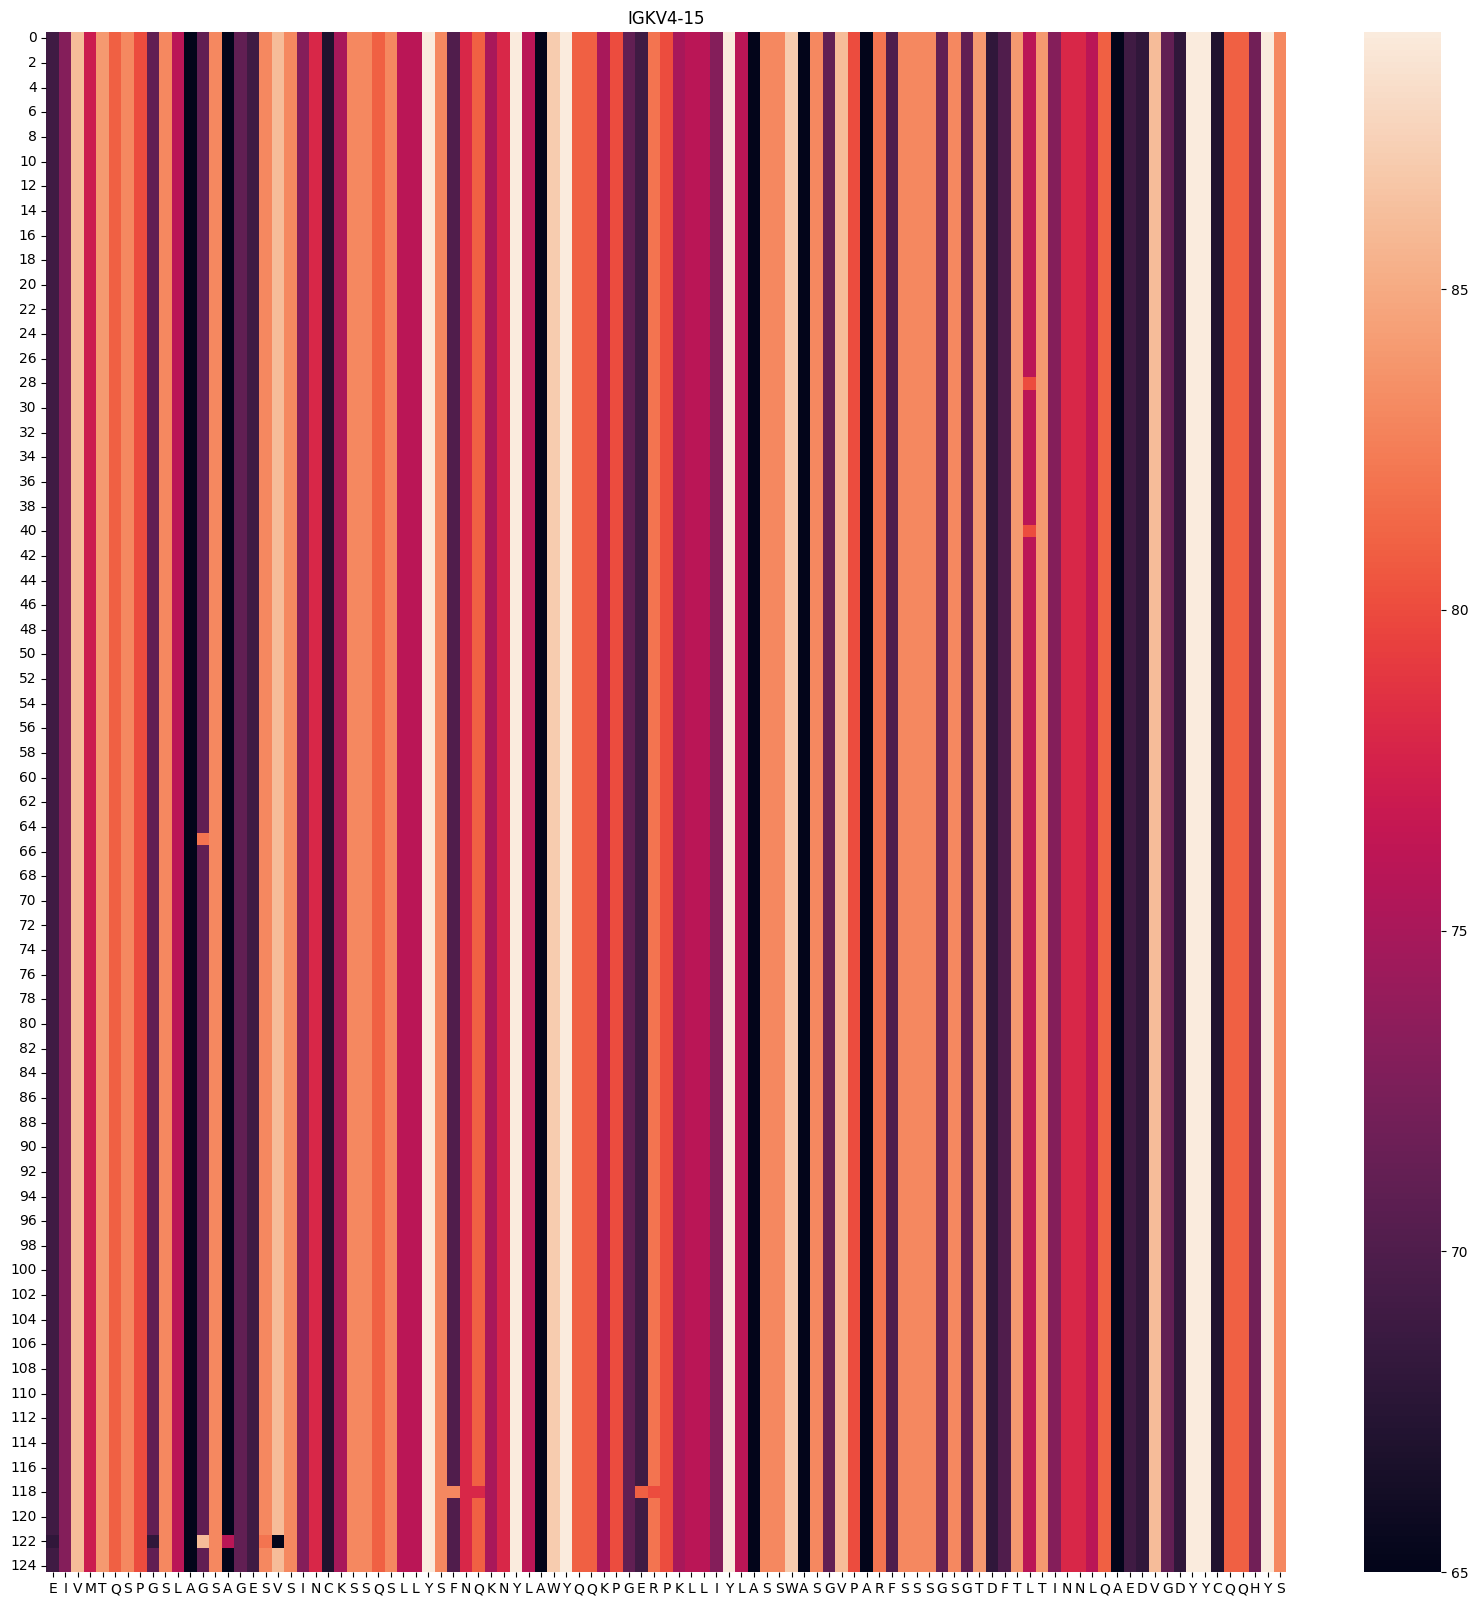

In [36]:
plt.figure(figsize=(20, 20))
sns.heatmap(annotate, xticklabels=list(tempdict[0]))
plt.title("IGKV4-15")

In [37]:
dog_vs_gene_cdr1 = entire_dataframe.copy()
dog_vs_gene_cdr2 = entire_dataframe.copy()
dog_vs_gene_cdr1.drop(columns=['Breed'], inplace=True)
dog_vs_gene_cdr2.drop(columns=['Breed'], inplace=True)
# print(dog_vs_gene_cdr1)

            IGHV1-30  IGHV3-10  IGHV3-13  IGHV3-16  IGHV3-18  IGHV3-19  \
Dog                                                                      
CFA.117995  0.918367  0.989796       1.0  0.989796  0.979592  0.989796   
Beagle04    0.846939  0.989796       1.0  1.000000  0.938776  0.918367   
Beagle02    0.000000  1.000000       1.0  1.000000  0.979592  0.979592   
Beagle03    0.908163  0.959184       1.0  1.000000  0.877551  0.928571   
Beagle01    0.000000  1.000000       1.0  1.000000  0.989796  1.000000   
...              ...       ...       ...       ...       ...       ...   
YORK000003  0.785714  0.989796       1.0  1.000000  0.959184  0.979592   
YORK000002  0.000000  1.000000       1.0  1.000000  0.979592  0.989796   
YORK000001  0.000000  1.000000       1.0  1.000000  0.969388  0.948980   
YORK000004  0.785714  0.989796       1.0  1.000000  0.969388  0.989796   
YORK000005  0.000000  1.000000       1.0  1.000000  0.979592  0.948980   

             IGHV3-2  IGHV3-23  IGHV3

In [58]:
import os
import pandas as pd
from collections import defaultdict
from Bio.Seq import Seq
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

genes = ['CDR-IGHV', 'CDR-IGKV', 'CDR-IGLV']
# genes = ['CDR-IGLV']
for g in genes:
    print(f"\nProcessing gene group: {g}")
    curpath = f"/content/drive/MyDrive/Purdue/Elancco/{g}"

    for d in os.listdir(curpath):
        try:
            dog_dict = pd.read_csv(f"{curpath}/{d}")
            CDR1_temp = {}
            CDR2_temp = {}
        except Exception as e:
            print(f"Could not read file {d}: {e}")
            continue

        # Build full sequence
        dog_dict['full'] = (
            dog_dict['L-FR1'] + dog_dict['L-CDR1'] +
            dog_dict['L-FR2'] + dog_dict['L-CDR2'] +
            dog_dict['L-FR3'] + dog_dict['L-CDR3']
        )

        # Extract clean gene name
        def extract_gene(raw_gene):
            try:
                return raw_gene.split('_')[1].split('(')[0]
            except Exception:
                return raw_gene

        dog_dict['Gene'] = dog_dict['Gene'].apply(extract_gene)

        dog = defaultdict(float)
        dog_name = d.split("_")[0]

        for gene, ref_seq in cs_dict.items():
            match_rows = dog_dict[dog_dict['Gene'] == gene]

            # print(cdr_1)


            if match_rows.empty:
                continue
            # if gene in ['IGKV2-11', 'IGKV4-15']:
            #     continue

            # print(match_rows)
            # print(dog_dict['L-CDR1'])
            cdr_1 = match_rows['L-CDR1'].values[0]
            cdr_1 = cdr_1.replace("-", "").replace("_", "")
            # print(cdr_1)

            cdr_2 = match_rows['L-CDR2'].values[0]
            cdr_2 = cdr_2.replace("-", "").replace("_", "")

            sample_seq = match_rows['full'].values[0]
            sample_seq = sample_seq.replace("-", "").replace("_", "")

            CDR1_temp[gene] = len(cdr_1)
            CDR2_temp[gene] = len(cdr_2)

        for k in CDR1_temp.keys():
            # print(k)
            dog_vs_gene_cdr1.loc[dog_name, k] = CDR1_temp[k]
            dog_vs_gene_cdr2.loc[dog_name, k] = CDR2_temp[k]
        dog_vs_gene_cdr1.loc[dog_name, ['Breed']] = cleared_mapping.loc[dog_name].Breed
        dog_vs_gene_cdr2.loc[dog_name, ['Breed']] = cleared_mapping.loc[dog_name].Breed
        dog['Breed'] = cleared_mapping.loc[dog_name].Breed if dog_name in cleared_mapping.index else "Unknown"

        # Save to final DataFrame
        entire_dataframe.loc[dog_name, dog.keys()] = dog.values()
        dog['Dog'] = dog_name


Streaming output truncated to the last 5000 lines.
65  IGLV3-2  SYVLTQSPS-VSVTLGQTASITCRGN  SIG------RKD  VHWYQQKPGQAPLLIIY   

        L-CDR2                                    L-FR3         L-CDR3  \
65  ND-------N  SQPSGIP-ERFSGTN--SGITATLTISEAQTKDEADYYC  QV---------WE   

                                                 full  
65  SYVLTQSPS-VSVTLGQTASITCRGNSIG------RKDVHWYQQKP...  
       Gene                       L-FR1        L-CDR1              L-FR2  \
64  IGLV3-3  SYVLTQLPS-KNVTLRQPAHITCEGD  SIG------SKS  VHWYQQKLGQAPVLIIY   

        L-CDR2                                    L-FR3         L-CDR3  \
64  SD-------S  SRPSGIP-ERFSSAN--SGNTATLTISGALAVDEADYYC  QVW--------DS   

                                                 full  
64  SYVLTQLPS-KNVTLRQPAHITCEGDSIG------SKSVHWYQQKL...  
       Gene                       L-FR1        L-CDR1              L-FR2  \
63  IGLV3-4  PTGLNQAPS-MLVALGQMETITCSGD  ILG------KRY  AYWYQHKPSQAPVLLIN   

        L-CDR2                              

In [60]:
# dog_vs_gene_cdr1
dog_vs_gene_cdr1 = dog_vs_gene_cdr1.fillna(value=0)
dog_vs_gene_cdr2 = dog_vs_gene_cdr2.fillna(value=0)
dog_vs_gene_cdr1 = dog_vs_gene_cdr1.sort_values(by='sum')
dog_vs_gene_cdr2 = dog_vs_gene_cdr1.sort_values(by='sum')
# CDR1 = CDR1.dropna()


In [41]:
dog_vs_gene_cdr1.to_csv('CDR1.csv', index=True)
dog_vs_gene_cdr2.to_csv('CDR2.csv', index=True)

In [61]:
dog_vs_gene_cdr1

,IGHV1-30,IGHV3-10,IGHV3-13,IGHV3-16,IGHV3-18,IGHV3-19,IGHV3-2,IGHV3-23,IGHV3-24,IGHV3-3,...,IGLV8-102,IGLV8-108,IGLV8-128,IGLV8-161,IGLV8-36,IGLV8-74-1,IGLV8-93,IGLV8-99,sum,Breed
Dog,,,,,,,,,,,,,,,,,,,,,
CLUPSE000001,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,106.326451,Wolf
BRMD000003,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,106.777012,Bernese Mountain Dog
CLUPRU000001,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,106.849252,Wolf
CLUPKG000001,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,106.998406,Wolf
BOUV000001,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,107.033445,Bouvier des Flandres
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GOLD000007,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,110.327539,Golden Retriever
FBUL000003,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,110.335767,French Bulldog
GOLD000003,7.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,110.377044,Golden Retriever


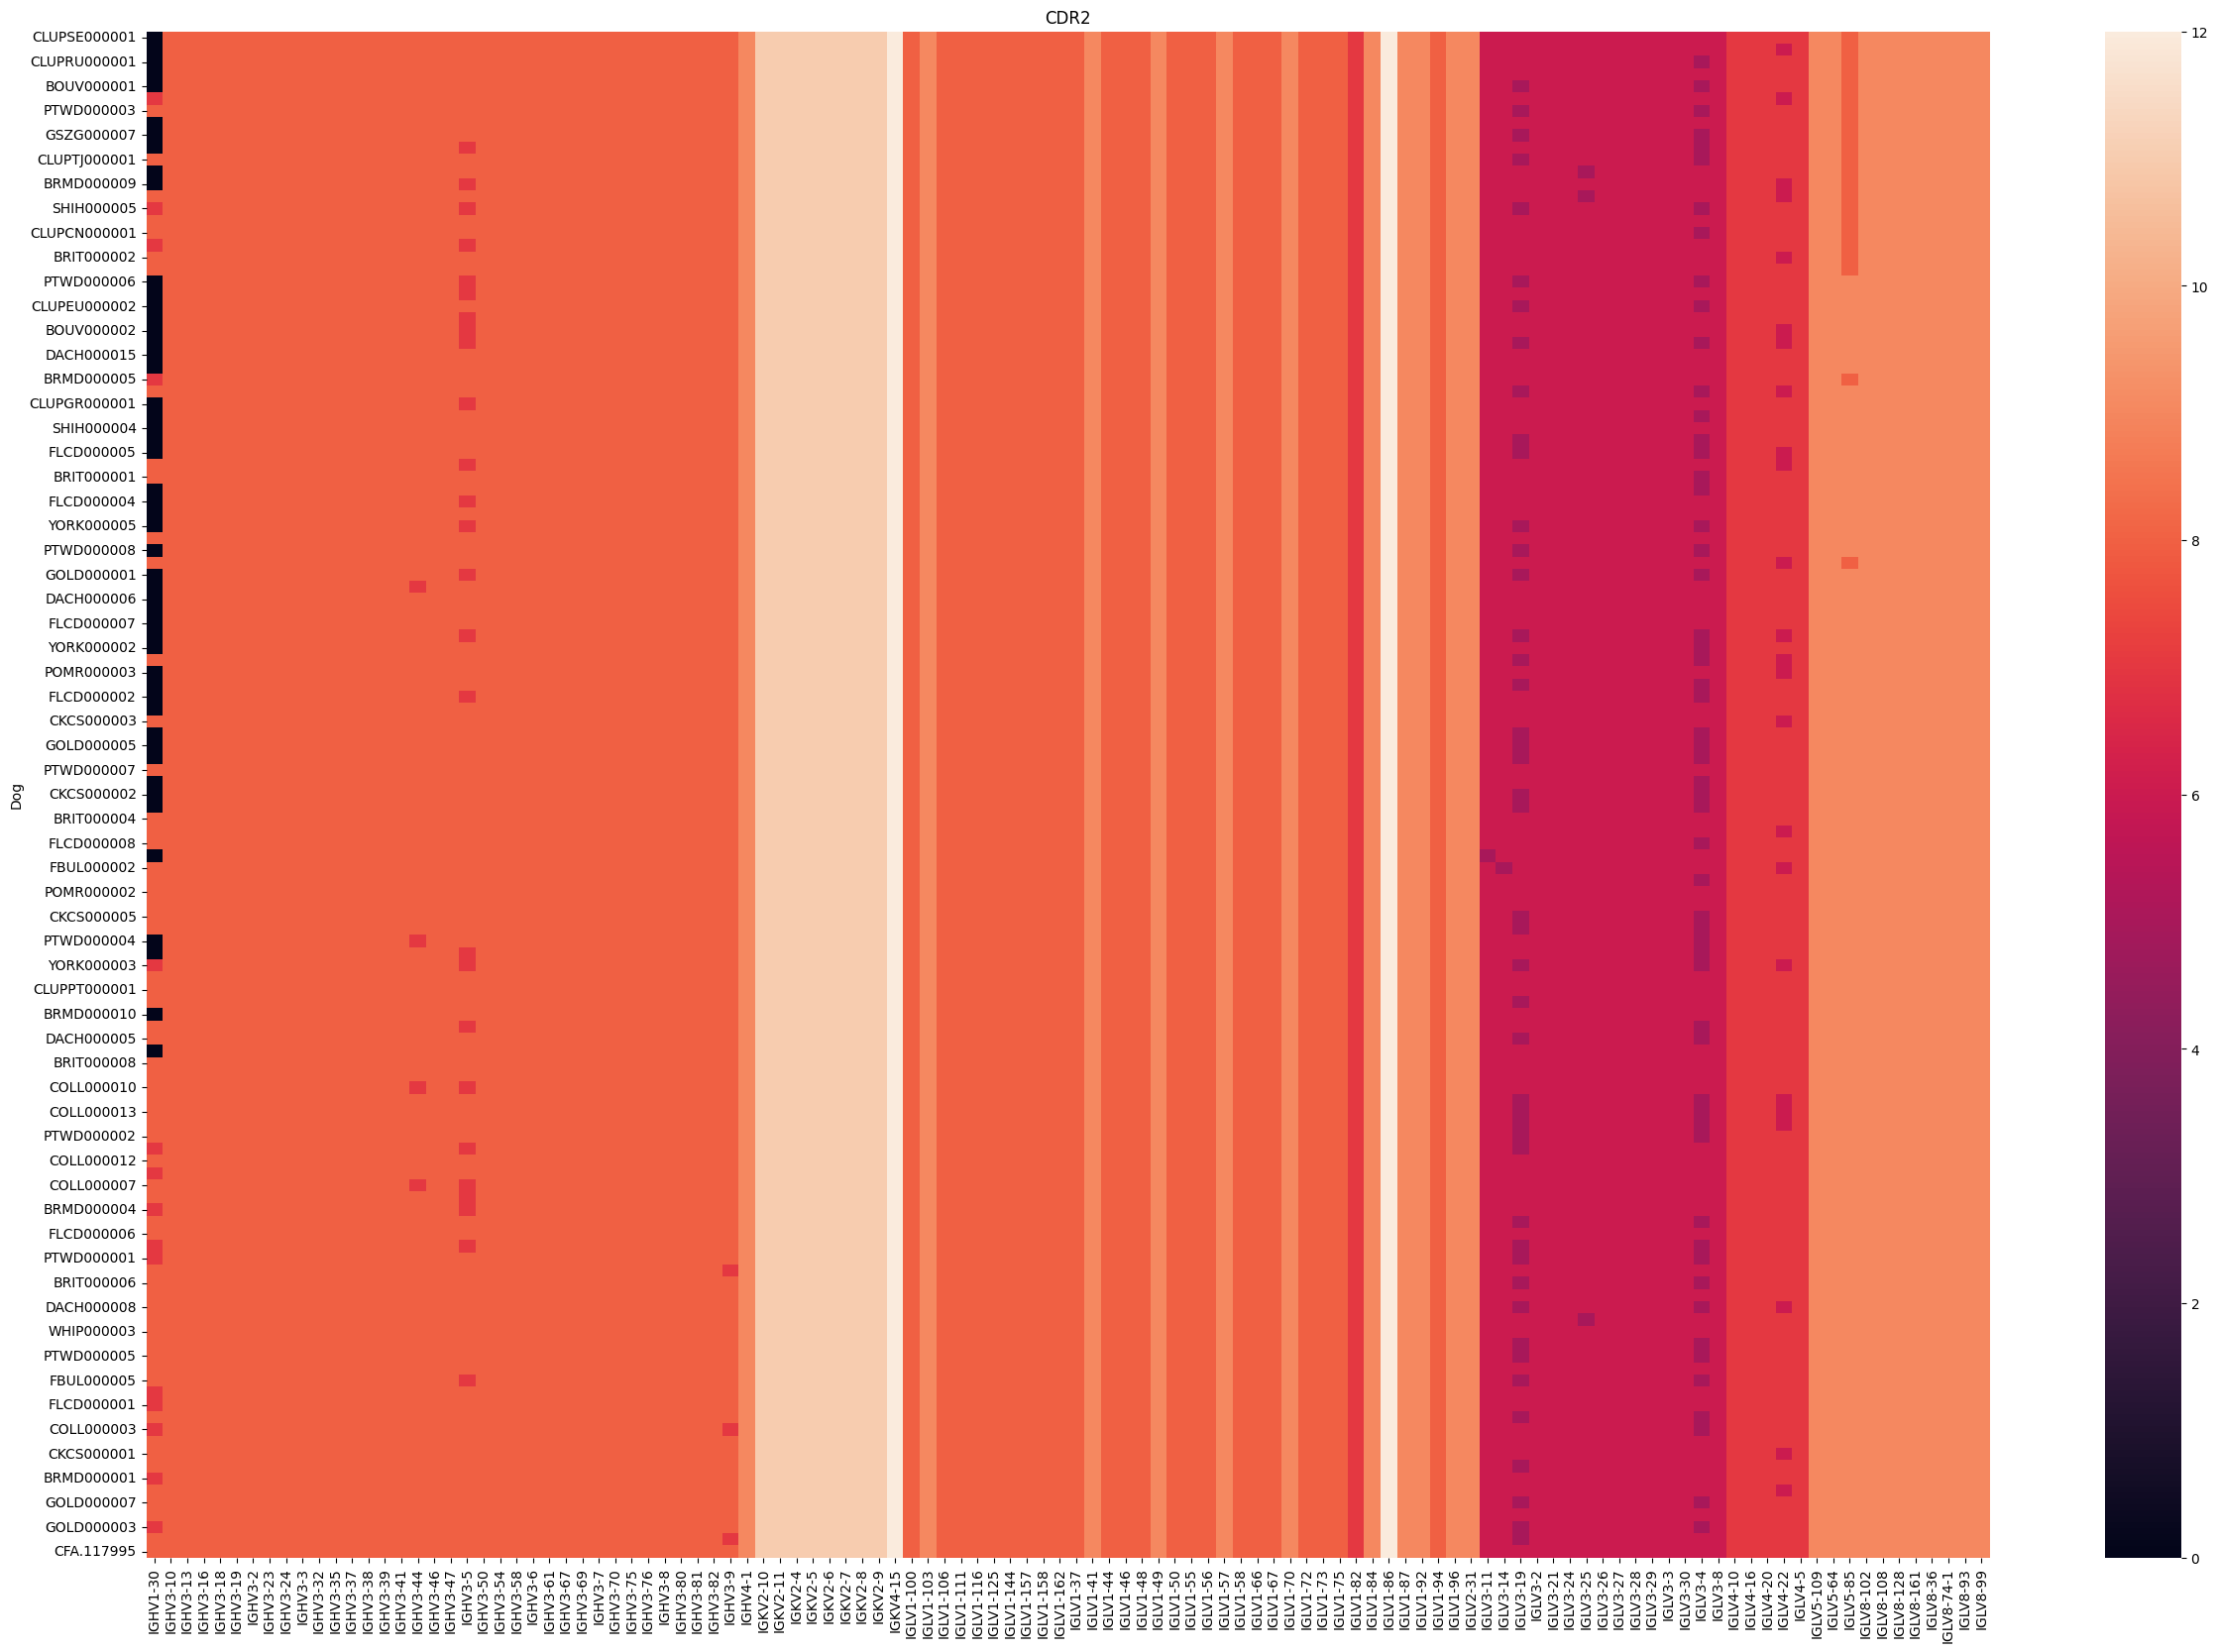

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 20))
f = sns.heatmap(dog_vs_gene_cdr2.drop(columns=['Breed', 'sum']), ax=ax)

f.set_title("CDR2")
plt.savefig("CDR2.jpg", bbox_inches="tight", pad_inches=0, dpi=300)
